# Penarikan Data

Penarikan data atau yang lebih dikenal dengan istilah scrapping merupakan proses penarikan data tertentu dari suatu website.

In [ ]:
#install google-play-scraper, saat pertama kali digunakan saja
!pip install google-play-scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#install library yang dibutuhkan
from google_play_scraper import app

import pandas as pd

import numpy as np

In [ ]:
# Scrapping semua ulasan

from google_play_scraper import Sort, reviews_all

result = reviews_all(
    'id.bmri.livin', #ambil linknya aplikasi
    sleep_milliseconds=0, # defaultnya 0
    lang='id', # pilih bahasa, defaultnya 'en'
    country='id', # pilih negara, defaultnya 'us'
    sort=Sort.NEWEST, # sortit ulasan, defaultnya Sort.NEWEST (sortir berdasarkan terbaru), bisa diganti Sort.MOST_RELEVANT (sortir berdasarkan relevan)
)

In [ ]:
# Scrapping beberapa ulasan

from google_play_scraper import Sort, reviews

result, continuation_token = reviews(
    'id.bmri.livin', #ambil linknya aplikasi
    lang='id', # pilih bahasa, defaultnya 'en'
    country='id',# pilih negara, defaultnya 'us'
    sort=Sort.NEWEST, # sortit ulasan, defaultnya Sort.NEWEST (sortir berdasarkan terbaru), bisa diganti Sort.MOST_RELEVANT (sortir berdasarkan relevan)
    count=200, # jumlah ulasan, defaultnya 100
    filter_score_with= None # memilih rating, defaultnya None bisa diganti rating 1-5
)


In [ ]:
# membuat dataframe
datascrapping = pd.DataFrame(np.array(result),columns=['review'])
# memasukan dataframe ke kolom masing2
datascrapping = datascrapping.join(pd.DataFrame(datascrapping.pop('review').tolist()))
#urutin ulasan berdasarkan tanggal
urutin = datascrapping.sort_values(by='at', ascending=False)
#ambil peubah yang akan digunakan
datascrapping = urutin[['userName','at', 'score', 'content']]

datascrapping

,userName,at,score,content
0,Farida Aja,2023-02-06 12:10:47,2,Setiap membuka aplikasi selalu harus login ata...
1,Joko Wahono,2023-02-06 11:44:54,1,"Beberapa kali sudah unistal, kemudian instal l..."
2,tebs thumb,2023-02-06 11:19:25,2,Tidak bisa masuk error' terus
3,Wisnu Mega,2023-02-06 11:13:18,1,Buat ngirim susahnya minta ampun
4,Rama Dhani,2023-02-06 11:01:50,1,Kenapa lagi ngecek saldo malah di suruh verifi...
...,...,...,...,...
195,Ag Bindiv9,2023-02-04 16:45:21,1,Ini kenapa ya seharian ga bisa kebuka mbangking
196,Ilham Hakim,2023-02-04 16:38:17,5,"Hi min, apa nunggu kwrtu datang dulu untuk bis..."
197,fajar kobain,2023-02-04 16:21:18,2,"Keseringan error sekarang , apalagi disaat kep..."
198,Dhimas Sutrisno,2023-02-04 16:18:39,1,"Aplikasinya parah, kalo malam sering error. Ga..."


In [ ]:
datascrapping.to_csv("datascrapping.csv", index = False)  #save file csv

# Pemilahan dan Pelabelan Data

Pemilahan data dan pelabelan manual dilakukan di spreadsheets https://docs.google.com/spreadsheets/d/1EZqjg4xGdQpNlTKTeP9H32oYPQ5DRMRsDKsGse99vI0/edit#gid=207884271

**Pemilahan data** dilakukan untuk memaksimalkan dataset penelitian dengan menghapus


1. ulasan tidak relevan (error)
2. ulasan duplikat username (ambil yang terbaru)
3. ulasan duplikat content (ambil yang yg paling awal)
4. ulasan dengan username tidak sesuai format


**Pelabelan manual** dengan memasukan ulasan ke dalam kelas sentimen positif atau negatif

# Praprosesing Data

**Praposesing data** merupakan proses yang dilakukan untuk mengubah data mentah yang akan digunakan menjadi data yang lebih terstruktur agar memudahkan sistem dalam membaca data. tahapan praprosesing data terdiri atas beberapa bagian antara lain :

1. Cleaning
2. Case Folding
3. Tokenisasi
4. Normalisasi
5. Stopwords Removal
6. Steeming

## kata bu rahma hanya pakai kata yg bermakna

In [ ]:
#install library yang dibutuhkan
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

#input data setelah di import ke google colab
dataset = pd.read_csv("databunda.csv", encoding = "ISO-8859-1")
#merubah data menjadi bentuk string
dataset['at'] = dataset['at'].astype(str)
dataset['score'] = dataset['score'].astype(str)
praprosesing = dataset[['userName','at','score','content','Sentimen']]

# mempersiapkan library cleaning
import re
import string


# membuat fungsi cleaning
def cleaning(ulasan):
  # Remove mentions
  ulasan = re.sub("@\S+", " ", ulasan)
  # Remove hashtag
  ulasan = re.sub(r'#\S+', ' ', ulasan)
  # Remove url
  ulasan = re.sub(r'https*\S+', ' ', ulasan)
  # Remove Unicode
  ulasan = re.sub(r'[^\x00-\x7F]+', ' ', ulasan)
  # Remove punctuations
  ulasan = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', ulasan)
  # Remove the numbers
  ulasan = re.sub(r'[0-9]', ' ', ulasan)
  # remove newline
  ulasan.replace('\n', ' ')
  # Remove the doubled space
  ulasan = re.sub(r'\s{2,}', ' ', ulasan)
  # Remove single character
  ulasan = re.sub(r'\b[a-zA-Z]\b', ' ', ulasan)
  return ulasan

praprosesing['cleaning'] = praprosesing['content'].apply(cleaning)
praprosesing['casefolding'] = praprosesing['cleaning'].str.lower()

# mempersiapkan library tokenisasi
import nltk
#nltk.download() # ketik 'd' lalu 'all'
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

# membuat fungsi tokenisasi
def tokenisasi (ulasan) :
    ulasan = nltk.word_tokenize(ulasan)
    return (ulasan)

praprosesing['tokenisasi'] = praprosesing['casefolding'].apply(tokenisasi)

# mempersiapkan kamus normalisasi
kamus = pd.read_csv("colloquial-indonesian-lexicon.csv")

kamus_normalisasi = {}

for index, row in kamus.iterrows():
    if row[0] not in kamus_normalisasi:
        kamus_normalisasi[row[0]] = row[1]

# membuat fungsi normalisasi
def normalisasi(ulasan):
    return [kamus_normalisasi[kata] if kata in kamus_normalisasi else kata for kata in ulasan]

praprosesing['normalisasi'] = praprosesing['tokenisasi'].apply(lambda x: normalisasi(x))

# mempersiapkan kamus stopwords (NLTK)
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwordsNLTK = stopwords.words('indonesian')

# mempersiapkan kamus stopwords (Sastrawi)
!pip install sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
stop_factory = StopWordRemoverFactory()

# menambahkan daftar kata stopword manual
more_stopword = ['nya','sih']

# menggabungkan kamus stopword
stopwords = stop_factory.get_stop_words()+more_stopword+stopwordsNLTK

# menghapus daftar kata stopword manual
#stopwords.remove ('yang')
stopwords=set(stopwords)

def stopwordsremoval(ulasan):
  return [kata for kata in ulasan if kata not in stopwords]


praprosesing['stopwordsremoval'] = praprosesing['normalisasi'].apply(lambda x: stopwordsremoval(x))
# mempersiapkan library stemming
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# membuat kamus stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi stemming
def stemming(ulasan):
    ulasan = [stemmer.stem(kata) for kata in ulasan]
    return ulasan

praprosesing['stemming'] = praprosesing['stopwordsremoval'].apply(lambda x: stemming(x))
# membandingkan hasil sebelum dan sesudah praprosesing
praprosesing['sebelum praprosesing'] = praprosesing['content']
praprosesing['sesudah praprosesing'] = praprosesing['stemming']
praprosesing [['sebelum praprosesing','sesudah praprosesing']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,sebelum praprosesing,sesudah praprosesing
0,Bagus apknya,"[mantap, aplikasi]"
1,Kesel banget livin kuning skrng susah bgt buat...,"[kesel, banget, livin, kuning, susah, banget, ..."
2,Rusak .... Vermuk gak bisa teruss....,"[rusak, vermuk]"
3,"Lagi gangguan, ga bisa buat topup dana anjay.....","[ganggu, topup, dana, anjay, minggu]"
4,"Transaksi out saya muncul, masuk?","[transaksi, muncul, masuk]"
...,...,...
2808,"belum sebulan pake livin udh harus d update,bc...","[bulan, pakai, livin, update, baca, kayak, loh..."
2809,"Update mulu, tapi di lihat ga ada perubahan, k...","[update, mulu, lihat, ubah, update, ubah, upli..."
2810,Fitur lama lebih ok dripada fitur sekarang..up...,"[fitur, fitur, up, bukangnya, tambah, mantap, ..."
2811,Kebanyakan Update!!!!!,"[banyak, update]"


In [ ]:
# tokenisasi untuk peubah sebelum dilakukan praprosesing
praprosesing['peubah_awal'] = praprosesing['content'].apply(tokenisasi)

# menghitung kemunculan kata
frekuensi1 = {}
for ulasan in praprosesing['peubah_awal']:
    for kata in ulasan :
      total = frekuensi1.get(kata,0)
      frekuensi1[kata] = total + 1
frekuensi2 = {}
for ulasan in praprosesing['sesudah praprosesing']:
    for kata in ulasan :
      total = frekuensi2.get(kata,0)
      frekuensi2[kata] = total + 1

# menghitung kata yang
daftar_kata1 = frekuensi1.keys()
daftar_kata2 = frekuensi2.keys()
#for kata in daftar_kata:
#    print(kata, frekuensi1[kata])

def peubah1(ulasan) :
    return [frekuensi1[kata] for kata in ulasan]
def peubah2(ulasan) :
    return [frekuensi2[kata] for kata in ulasan]

print("Jumlah Peubah")
print("Sebelum Praprosesing" ,":", len(daftar_kata1))
print("Sesudah Praprosesing" ,":", len(daftar_kata2))

#mengambil data yang sudah di praprosesing
praprosesing['ulasan'] = praprosesing['sesudah praprosesing']
praprosesing['label manual'] = dataset['Sentimen']
databersih = praprosesing [['userName','at','score','content','ulasan','label manual']]

Jumlah Peubah
Sebelum Praprosesing : 4308
Sesudah Praprosesing : 1989


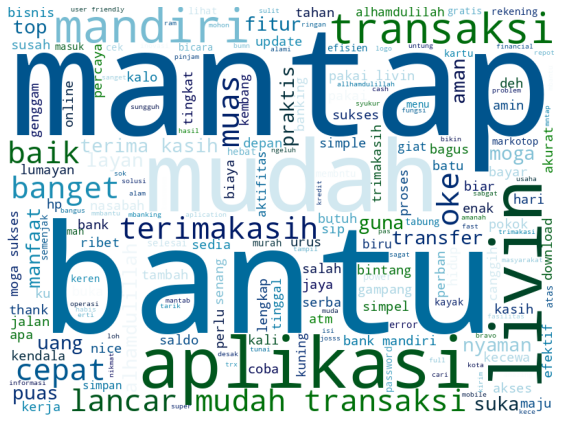

[('mantap', 491),
 ('bantu', 293),
 ('mudah', 233),
 ('livin', 159),
 ('aplikasi', 146),
 ('transaksi', 135),
 ('mandiri', 118),
 ('banget', 55),
 ('by', 50),
 ('cepat', 49)]

In [ ]:
# menyiapkan library yang akan digunakan
from wordcloud import WordCloud, ImageColorGenerator
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

# mengambil data yang memiliki kelas klasifikasi positif
data_positif = databersih.loc[databersih['label manual']=='positif']

# mengambil daftar kata dari data kelas positif
daftar_kata_positif=''
for ulasan in data_positif ['ulasan']:
    for kata in ulasan:
        daftar_kata_positif += ' '+(kata)

# membuat wordcloud dari daftar kata positif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='ocean', random_state=500, repeat=bool,
                             min_font_size = 1).generate(daftar_kata_positif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

from collections import Counter
Counter((daftar_kata_positif).split()).most_common(10)

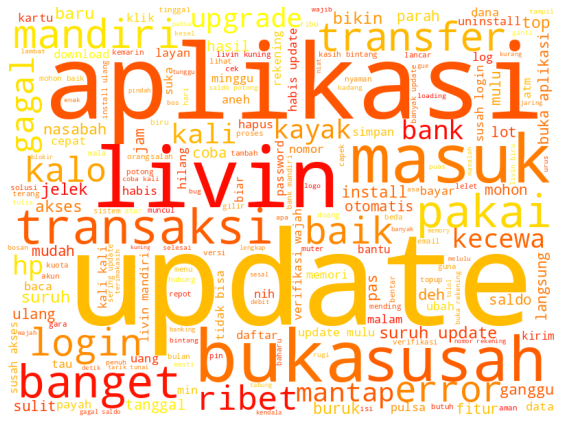

[('update', 710),
 ('aplikasi', 386),
 ('livin', 253),
 ('buka', 193),
 ('susah', 142),
 ('masuk', 133),
 ('mandiri', 113),
 ('transaksi', 100),
 ('kali', 92),
 ('login', 92)]

In [ ]:
# mengambil data yang memiliki kelas klasifikasi negatif
data_negatif = databersih.loc[databersih['label manual']=='negatif']

# mengambil daftar kata dari data kelas negatif
daftar_kata_negatif=''
for ulasan in data_negatif ['ulasan']:
    for kata in ulasan:
        daftar_kata_negatif += ' '+(kata)

# membuat wordcloud dari daftar kata negatif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='autumn', random_state=500,
                             min_font_size = 5).generate(daftar_kata_negatif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

from collections import Counter
Counter((daftar_kata_negatif).split()).most_common(10)

## Input data
Mempersiapkan data yang akan dilakukan praprosesing

In [ ]:
#install library yang dibutuhkan
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

#input data setelah di import ke google colab
dataset = pd.read_csv("databunda.csv", encoding = "ISO-8859-1")
#merubah data menjadi bentuk string
dataset['at'] = dataset['at'].astype(str)
dataset['score'] = dataset['score'].astype(str)

praprosesing = dataset[['userName','at','score','content','Sentimen']]
praprosesing

,userName,at,score,content,Sentimen
0,M Ariva Maulana,12/11/2022 0:26,5,Bagus apknya,positif
1,TOYOTA Lets Go Beyond,12/11/2022 0:38,1,Kesel banget livin kuning skrng susah bgt buat...,negatif
2,Aliya Mukti,12/11/2022 1:24,1,Rusak .... Vermuk gak bisa teruss....,negatif
3,dila azs87,12/11/2022 2:17,2,"Lagi gangguan, ga bisa buat topup dana anjay.....",negatif
4,I Wayan Suarjaya Suarjaya,12/11/2022 3:05,1,"Transaksi out saya muncul, masuk?",negatif
...,...,...,...,...,...
2808,Renita Sari,12/22/2022 23:47,1,"belum sebulan pake livin udh harus d update,bc...",negatif
2809,Ramli Lebu,12/22/2022 23:48,2,"Update mulu, tapi di lihat ga ada perubahan, k...",negatif
2810,Undi Karyana,12/22/2022 23:56,1,Fitur lama lebih ok dripada fitur sekarang..up...,negatif
2811,Bahtiar faqih,12/22/2022 23:57,3,Kebanyakan Update!!!!!,negatif


## **Cleaning**
bertujuan untuk membersihkan data dari karakter maupun elemen-elemen yang tidak dibutuhkan karena tidak dapat terbaca oleh sistem, seperti angka, emot icon, tanda baca, maupun karakter lain selain huruf.

In [ ]:
# mempersiapkan library cleaning
import re
import string


# membuat fungsi cleaning
def cleaning(ulasan):
  # Remove mentions
  ulasan = re.sub("@\S+", " ", ulasan)
  # Remove hashtag
  ulasan = re.sub(r'#\S+', ' ', ulasan)
  # Remove url
  ulasan = re.sub(r'https*\S+', ' ', ulasan)
  # Remove Unicode
  ulasan = re.sub(r'[^\x00-\x7F]+', ' ', ulasan)
  # Remove punctuations
  ulasan = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', ulasan)
  # Remove the numbers
  ulasan = re.sub(r'[0-9]', ' ', ulasan)
  # remove newline
  ulasan.replace('\n', ' ')
  # Remove the doubled space
  ulasan = re.sub(r'\s{2,}', ' ', ulasan)
  # Remove single character
  ulasan = re.sub(r'\b[a-zA-Z]\b', ' ', ulasan)
  return ulasan

praprosesing['cleaning'] = praprosesing['content'].apply(cleaning)
praprosesing[['content','cleaning','Sentimen']].head(10)

,content,cleaning,Sentimen
0,Bagus apknya,Bagus apknya,positif
1,Kesel banget livin kuning skrng susah bgt buat...,Kesel banget livin kuning skrng susah bgt buat...,negatif
2,Rusak .... Vermuk gak bisa teruss....,Rusak Vermuk gak bisa teruss,negatif
3,"Lagi gangguan, ga bisa buat topup dana anjay.....",Lagi gangguan ga bisa buat topup dana anjay ud...,negatif
4,"Transaksi out saya muncul, masuk?",Transaksi out saya muncul masuk,negatif
5,bagus bgt ni aplikasi. bisa semua,bagus bgt ni aplikasi bisa semua,positif
6,Untuk ngirim ke akun dana selalu gk bisa. Mana...,Untuk ngirim ke akun dana selalu gk bisa Mana ...,negatif
7,Aplikasi yang buruk,Aplikasi yang buruk,negatif
8,"Top up pulsa gk masuk,, tolong di perbaiki",Top up pulsa gk masuk tolong di perbaiki,negatif
9,Gak bisa daftar untuk akses foto tinggal harap...,Gak bisa daftar untuk akses foto tinggal harap...,negatif


## **Case Folding**
bertujuan untuk menyeragakan seluruh bentuk huruf kapital yang terdapat pada dataset menjadi huruf kecil (lower case).

In [ ]:
praprosesing['casefolding'] = praprosesing['cleaning'].str.lower()
praprosesing[['cleaning','casefolding','Sentimen']].head(10)

,cleaning,casefolding,Sentimen
0,Bagus apknya,bagus apknya,positif
1,Kesel banget livin kuning skrng susah bgt buat...,kesel banget livin kuning skrng susah bgt buat...,negatif
2,Rusak Vermuk gak bisa teruss,rusak vermuk gak bisa teruss,negatif
3,Lagi gangguan ga bisa buat topup dana anjay ud...,lagi gangguan ga bisa buat topup dana anjay ud...,negatif
4,Transaksi out saya muncul masuk,transaksi out saya muncul masuk,negatif
5,bagus bgt ni aplikasi bisa semua,bagus bgt ni aplikasi bisa semua,positif
6,Untuk ngirim ke akun dana selalu gk bisa Mana ...,untuk ngirim ke akun dana selalu gk bisa mana ...,negatif
7,Aplikasi yang buruk,aplikasi yang buruk,negatif
8,Top up pulsa gk masuk tolong di perbaiki,top up pulsa gk masuk tolong di perbaiki,negatif
9,Gak bisa daftar untuk akses foto tinggal harap...,gak bisa daftar untuk akses foto tinggal harap...,negatif


## **Tokenisasi**
bertujuan untuk memisahkan struktur teks ulasan menjadi potongan kata atau token yang dipisahkan menggunakan pembatas atau delimiter spasi.

In [ ]:
# mempersiapkan library tokenisasi
import nltk
#nltk.download() # ketik 'd' lalu 'all'
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

# membuat fungsi tokenisasi
def tokenisasi (ulasan) :
    ulasan = nltk.word_tokenize(ulasan)
    return (ulasan)

praprosesing['tokenisasi'] = praprosesing['casefolding'].apply(tokenisasi)
praprosesing[['casefolding','tokenisasi','Sentimen']].head(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,casefolding,tokenisasi,Sentimen
0,bagus apknya,"[bagus, apknya]",positif
1,kesel banget livin kuning skrng susah bgt buat...,"[kesel, banget, livin, kuning, skrng, susah, b...",negatif
2,rusak vermuk gak bisa teruss,"[rusak, vermuk, gak, bisa, teruss]",negatif
3,lagi gangguan ga bisa buat topup dana anjay ud...,"[lagi, gangguan, ga, bisa, buat, topup, dana, ...",negatif
4,transaksi out saya muncul masuk,"[transaksi, out, saya, muncul, masuk]",negatif
5,bagus bgt ni aplikasi bisa semua,"[bagus, bgt, ni, aplikasi, bisa, semua]",positif
6,untuk ngirim ke akun dana selalu gk bisa mana ...,"[untuk, ngirim, ke, akun, dana, selalu, gk, bi...",negatif
7,aplikasi yang buruk,"[aplikasi, yang, buruk]",negatif
8,top up pulsa gk masuk tolong di perbaiki,"[top, up, pulsa, gk, masuk, tolong, di, perbaiki]",negatif
9,gak bisa daftar untuk akses foto tinggal harap...,"[gak, bisa, daftar, untuk, akses, foto, tingga...",negatif


## **Normalisasi**
bertujuan untuk melakukan perbaikan pada kesalahan penulisan kata, penggunaan kata tidak baku, dan penggunaan kata yang memiliki makna sama atau sejenis menggunakan kamus Colloquial Indonesian Lexicon yang telah dimodifikasi dan ditambahkan secara manual agar sesuai dengan topik penelitian

In [ ]:
# mempersiapkan kamus normalisasi
kamus = pd.read_csv("colloquial-indonesian-lexicon-edit.csv")

kamus_normalisasi = {}

for index, row in kamus.iterrows():
    if row[0] not in kamus_normalisasi:
        kamus_normalisasi[row[0]] = row[1]

# membuat fungsi normalisasi
def normalisasi(ulasan):
    return [kamus_normalisasi[kata] if kata in kamus_normalisasi else kata for kata in ulasan]

praprosesing['normalisasi'] = praprosesing['tokenisasi'].apply(lambda x: normalisasi(x))
praprosesing[['tokenisasi','normalisasi','Sentimen']].head(10)

,tokenisasi,normalisasi,Sentimen
0,"[bagus, apknya]","[mantap, aplikasi]",positif
1,"[kesel, banget, livin, kuning, skrng, susah, b...","[kesel, banget, livin, kuning, sekarang, susah...",negatif
2,"[rusak, vermuk, gak, bisa, teruss]","[rusak, vermuk, tidak, bisa, terus]",negatif
3,"[lagi, gangguan, ga, bisa, buat, topup, dana, ...","[lagi, gangguan, tidak, bisa, buat, topup, dan...",negatif
4,"[transaksi, out, saya, muncul, masuk]","[transaksi, keluar, saya, muncul, masuk]",negatif
5,"[bagus, bgt, ni, aplikasi, bisa, semua]","[mantap, banget, ini, aplikasi, bisa, semua]",positif
6,"[untuk, ngirim, ke, akun, dana, selalu, gk, bi...","[untuk, mengirim, ke, akun, dana, selalu, tida...",negatif
7,"[aplikasi, yang, buruk]","[aplikasi, yang, buruk]",negatif
8,"[top, up, pulsa, gk, masuk, tolong, di, perbaiki]","[top, up, pulsa, tidak, masuk, tolong, di, per...",negatif
9,"[gak, bisa, daftar, untuk, akses, foto, tingga...","[tidak, bisa, daftar, untuk, akses, foto, ting...",negatif


## **Stopwords Removal**
bertujuan untuk menghilangkan kata penghubung, kata ganti orang, kata seruan, dan kata lain yang terdapat pada kamus stopwords karena tidak berpengaruh pada proses klasifikasi. Proses ini menggunakan gabungan dari kamus sastrawi dan natural languange toolkit (NLTK) yang telah dimodifikasi dan ditambahkan secara manual agar sesuai dengan topik penelitian

In [ ]:
# mempersiapkan kamus stopwords
kamus=pd.read_csv("stopwordsedit.csv" )
kamus_stopwords = np.array(kamus)

# membuat fungsi stopwords removal
def stopwordsremoval(ulasan):
    return [kata for kata in ulasan if kata not in kamus_stopwords]


praprosesing['stopwordsremoval'] = praprosesing['normalisasi'].apply(lambda x: stopwordsremoval(x))
praprosesing[['normalisasi','stopwordsremoval','Sentimen']].head(10)

,normalisasi,stopwordsremoval,Sentimen
0,"[mantap, aplikasi]","[mantap, aplikasi]",positif
1,"[kesel, banget, livin, kuning, sekarang, susah...","[kesel, banget, livin, kuning, susah, banget, ...",negatif
2,"[rusak, vermuk, tidak, bisa, terus]","[rusak, vermuk, tidak]",negatif
3,"[lagi, gangguan, tidak, bisa, buat, topup, dan...","[lagi, gangguan, tidak, buat, topup, dana, anj...",negatif
4,"[transaksi, keluar, saya, muncul, masuk]","[transaksi, keluar, muncul, masuk]",negatif
5,"[mantap, banget, ini, aplikasi, bisa, semua]","[mantap, banget, aplikasi, semua]",positif
6,"[untuk, mengirim, ke, akun, dana, selalu, tida...","[mengirim, akun, dana, tidak, transaksi, atas,...",negatif
7,"[aplikasi, yang, buruk]","[aplikasi, buruk]",negatif
8,"[top, up, pulsa, tidak, masuk, tolong, di, per...","[top, pulsa, tidak, masuk, tolong, perbaiki]",negatif
9,"[tidak, bisa, daftar, untuk, akses, foto, ting...","[tidak, daftar, akses, foto, tinggal, harap, p...",negatif


## **Stemming**
bertujuan untuk menguraikan kata pada ulasan menjadi bentuk kata dasar dengan menghapus imbuhan pada kata tersebut. Proses ini menggunakan kamus sastrawi sebagai daftar kata yang telah dimodifikasi dan ditambahkan secara manual agar sesuai dengan topik penelitian

In [ ]:
# mempersiapkan library stemming
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# membuat kamus stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi stemming
def stemming(ulasan):
    ulasan = [stemmer.stem(kata) for kata in ulasan]
    return ulasan

praprosesing['stemming'] = praprosesing['stopwordsremoval'].apply(lambda x: stemming(x))
praprosesing[['stopwordsremoval','stemming','Sentimen']].head(10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 774.9 kB/s eta 0:00:00


,stopwordsremoval,stemming,Sentimen
0,"[mantap, aplikasi]","[mantap, aplikasi]",positif
1,"[kesel, banget, livin, kuning, susah, banget, ...","[kesel, banget, livin, kuning, susah, banget, ...",negatif
2,"[rusak, vermuk, tidak]","[rusak, vermuk, tidak]",negatif
3,"[lagi, gangguan, tidak, buat, topup, dana, anj...","[lagi, ganggu, tidak, buat, topup, dana, anjay...",negatif
4,"[transaksi, keluar, muncul, masuk]","[transaksi, keluar, muncul, masuk]",negatif
5,"[mantap, banget, aplikasi, semua]","[mantap, banget, aplikasi, semua]",positif
6,"[mengirim, akun, dana, tidak, transaksi, atas,...","[kirim, akun, dana, tidak, transaksi, atas, jm...",negatif
7,"[aplikasi, buruk]","[aplikasi, buruk]",negatif
8,"[top, pulsa, tidak, masuk, tolong, perbaiki]","[top, pulsa, tidak, masuk, tolong, baik]",negatif
9,"[tidak, daftar, akses, foto, tinggal, harap, p...","[tidak, daftar, akses, foto, tinggal, harap, b...",negatif


## Compare Hasil dan Peubah


Membandingkan ulasan sebelum dan sesudah dilakukan praprosesing

In [ ]:
# membandingkan hasil sebelum dan sesudah praprosesing
praprosesing['sebelum praprosesing'] = praprosesing['content']
praprosesing['sesudah praprosesing'] = praprosesing['stemming']
praprosesing [['sebelum praprosesing','sesudah praprosesing']]

,sebelum praprosesing,sesudah praprosesing
0,Bagus apknya,"[mantap, aplikasi]"
1,Kesel banget livin kuning skrng susah bgt buat...,"[kesel, banget, livin, kuning, susah, banget, ..."
2,Rusak .... Vermuk gak bisa teruss....,"[rusak, vermuk, tidak]"
3,"Lagi gangguan, ga bisa buat topup dana anjay.....","[lagi, ganggu, tidak, buat, topup, dana, anjay..."
4,"Transaksi out saya muncul, masuk?","[transaksi, keluar, muncul, masuk]"
...,...,...
2808,"belum sebulan pake livin udh harus d update,bc...","[bulan, pakai, livin, sudah, harus, update, ba..."
2809,"Update mulu, tapi di lihat ga ada perubahan, k...","[update, mulu, lihat, tidak, ada, ubah, kalau,..."
2810,Fitur lama lebih ok dripada fitur sekarang..up...,"[fitur, lama, lebih, ok, fitur, bukangnya, tam..."
2811,Kebanyakan Update!!!!!,"[banyak, update]"


Membandingkan jumlah peubah sebelum dan sesudah dilakukan praprosesing

In [ ]:
# tokenisasi untuk peubah sebelum dilakukan praprosesing
praprosesing['peubah_awal'] = praprosesing['content'].apply(tokenisasi)

# menghitung kemunculan kata
frekuensi1 = {}
for ulasan in praprosesing['peubah_awal']:
    for kata in ulasan :
      total = frekuensi1.get(kata,0)
      frekuensi1[kata] = total + 1
frekuensi2 = {}
for ulasan in praprosesing['sesudah praprosesing']:
    for kata in ulasan :
      total = frekuensi2.get(kata,0)
      frekuensi2[kata] = total + 1

# menghitung kata yang
daftar_kata1 = frekuensi1.keys()
daftar_kata2 = frekuensi2.keys()
#for kata in daftar_kata:
#    print(kata, frekuensi1[kata])

def peubah1(ulasan) :
    return [frekuensi1[kata] for kata in ulasan]
def peubah2(ulasan) :
    return [frekuensi2[kata] for kata in ulasan]

print("Jumlah Peubah")
print("Sebelum Praprosesing" ,":", len(daftar_kata1))
print("Sesudah Praprosesing" ,":", len(daftar_kata2))

Jumlah Peubah
Sebelum Praprosesing : 4308
Sesudah Praprosesing : 1912


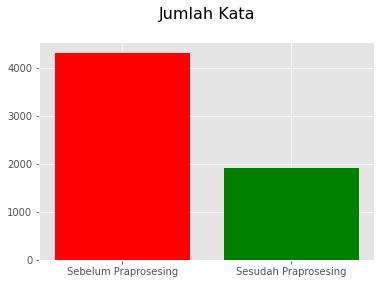

In [ ]:
#!pip install matplotlib
from matplotlib import pyplot as plt
from matplotlib import style

style.use('ggplot')

x = [0, 1]
y = [4308,1912]

fig, ax = plt.subplots()


ax.bar(x, y, align='center', color=('red','green'))

ax.set_title('Jumlah Kata\n', size=16)
ax.set_xticks(x)
ax.set_xticklabels(("Sebelum Praprosesing","Sesudah Praprosesing"), size=10)

plt.show()

menyimpan ulasan yang sudah dilakukan praprosesing



In [ ]:
#mengambil data yang sudah di praprosesing
praprosesing['ulasan'] = praprosesing['sesudah praprosesing']
praprosesing['label manual'] = dataset['Sentimen']
databersih = praprosesing [['userName','at','score','content','ulasan','label manual']]
databersih.head(10)

,userName,at,score,content,ulasan,label manual
0,M Ariva Maulana,12/11/2022 0:26,5,Bagus apknya,"[mantap, aplikasi]",positif
1,TOYOTA Lets Go Beyond,12/11/2022 0:38,1,Kesel banget livin kuning skrng susah bgt buat...,"[kesel, banget, livin, kuning, susah, banget, ...",negatif
2,Aliya Mukti,12/11/2022 1:24,1,Rusak .... Vermuk gak bisa teruss....,"[rusak, vermuk, tidak]",negatif
3,dila azs87,12/11/2022 2:17,2,"Lagi gangguan, ga bisa buat topup dana anjay.....","[lagi, ganggu, tidak, buat, topup, dana, anjay...",negatif
4,I Wayan Suarjaya Suarjaya,12/11/2022 3:05,1,"Transaksi out saya muncul, masuk?","[transaksi, keluar, muncul, masuk]",negatif
5,Josua Simbolon,12/11/2022 3:19,5,bagus bgt ni aplikasi. bisa semua,"[mantap, banget, aplikasi, semua]",positif
6,Aris Verlando Setiawan,12/11/2022 3:34,1,Untuk ngirim ke akun dana selalu gk bisa. Mana...,"[kirim, akun, dana, tidak, transaksi, atas, jm...",negatif
7,syafrizal efendi,12/11/2022 3:36,1,Aplikasi yang buruk,"[aplikasi, buruk]",negatif
8,Anang Setyowahyudi,12/11/2022 4:41,1,"Top up pulsa gk masuk,, tolong di perbaiki","[top, pulsa, tidak, masuk, tolong, baik]",negatif
9,Ari Tobulus Tri Berlian Purba,12/11/2022 4:42,1,Gak bisa daftar untuk akses foto tinggal harap...,"[tidak, daftar, akses, foto, tinggal, harap, b...",negatif


In [ ]:
databersih.to_csv("databersih.csv", index = False)  #save file csv

## Word Cloud Setelah Praprosesing
Awan kata merupakan kumpulan kata yang memiliki frekuensi kemunculan paling banyak pada suatu data teks. Semakin besar ukuran kata pada awan kata menunjukkan semakin sering kata tersebut muncul dalam data (Adiyana dan Hakim 2015).

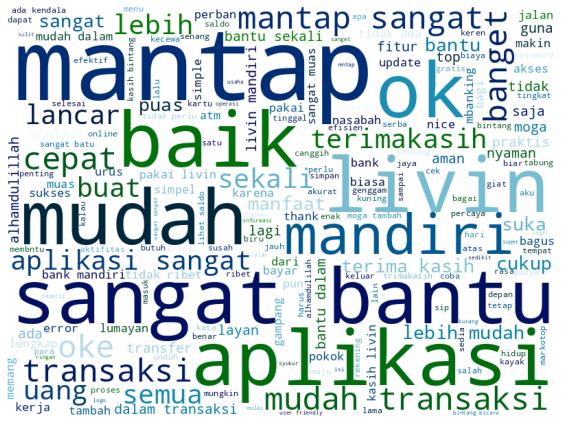

In [ ]:
# menyiapkan library yang akan digunakan
from wordcloud import WordCloud, ImageColorGenerator
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

# mengambil data yang memiliki kelas klasifikasi positif
data_positif = databersih.loc[databersih['label manual']=='positif']

# mengambil daftar kata dari data kelas positif
daftar_kata_positif=''
for ulasan in data_positif ['ulasan']:
    for kata in ulasan:
        daftar_kata_positif += ' '+(kata)

# membuat wordcloud dari daftar kata positif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='ocean', random_state=500, repeat=bool,
                             min_font_size = 1).generate(daftar_kata_positif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [ ]:
from collections import Counter
Counter((daftar_kata_positif).split()).most_common(10)

[('mantap', 491),
 ('sangat', 395),
 ('bantu', 293),
 ('mudah', 237),
 ('livin', 161),
 ('aplikasi', 151),
 ('transaksi', 139),
 ('mandiri', 120),
 ('baik', 104),
 ('ok', 101)]

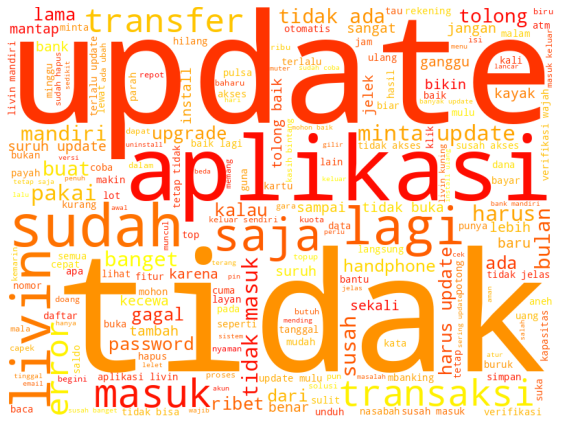

In [ ]:
# mengambil data yang memiliki kelas klasifikasi negatif
data_negatif = databersih.loc[databersih['label manual']=='negatif']

# mengambil daftar kata dari data kelas negatif
daftar_kata_negatif=''
for ulasan in data_negatif ['ulasan']:
    for kata in ulasan:
        daftar_kata_negatif += ' '+(kata)

# membuat wordcloud dari daftar kata negatif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='autumn', random_state=500,
                             min_font_size = 5).generate(daftar_kata_negatif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

In [ ]:
from collections import Counter
Counter((daftar_kata_negatif).split()).most_common(10)

[('tidak', 789),
 ('update', 739),
 ('aplikasi', 392),
 ('livin', 256),
 ('masuk', 240),
 ('sudah', 234),
 ('lagi', 194),
 ('saja', 176),
 ('ada', 144),
 ('susah', 142)]

# Pemodelan *Lexicon-based*

Pendekatan berbasis kamus (lexicon-based) merupakan metode pengklasifikasian pada analisis sentimen dengan konsep dasar memberikan nilai polaritas untuk masing-masing kata pada suatu ulasan berdasarkan kamus atau daftar kata sebagai pembanding serta penghitung dalam menentukan hasil prediksi sentimen pada suatu ulasan (Yudianto et al. 2022)

## Indonesia Sentiment Lexicon (InSet)
Kamus indonesia Sentiment (InSet) merupakan salah satu kamus sentimen berbahasa indonesia yang dibuat pada penelitian Koto dan Rahmaningtyas (2017). Kamus InSet terdiri atas 3.609 kata positif dan 6.609 kata negatif dalam Bahasa Indonesia

In [ ]:
# analisis sentimen menggunakan kamus indonesia sentiment lexicon (source : https://github.com/fajri91/InSet)

# mempersiapkan kamus sentimen positif dan negatif
lexicon_positive = dict()
import csv
with open('lexicon_positive.csv', 'r') as csvfile:
    kamus = csv.reader(csvfile, delimiter=',')
    for row in kamus:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative.csv', 'r') as csvfile:
    kamus = csv.reader(csvfile, delimiter=',')
    for row in kamus:
        lexicon_negative[row[0]] = int(row[1])

# membuat fungsi pemodelan lexicon-based
def sentiment_analysis_lexicon_indonesia(ulasan):
    score = 0
    jumlah_kata = 0
    for kata in ulasan:
        if (kata in lexicon_positive):
            score = score + lexicon_positive[kata]
            jumlah_kata = jumlah_kata + 1
    for kata in ulasan:
        if (kata in lexicon_negative):
            score = score + lexicon_negative[kata]
            jumlah_kata = jumlah_kata - 1

    polarity=''
    if (score > 0):
        polarity = 'positif'
    elif (score < 0):
        polarity = 'negatif'
    else:
        score = jumlah_kata
        if (score > 0):
             polarity = 'positif'
        elif (score < 0):
            polarity = 'negatif'
        else :
            polarity = 'netral'


    return score, polarity

In [ ]:
# hasil klasifikasi sentimen menggunakan lexicon-based
pd.options.mode.chained_assignment = None
hasilmodel1 = databersih['ulasan'].apply(sentiment_analysis_lexicon_indonesia)
hasilmodel1 = list(zip(*hasilmodel1))

# memasukan hasil klasifikasi ke dataset
databersih['nilai polaritas'] = hasilmodel1[0]
databersih['sentimen lexicon'] = hasilmodel1[1]

print(databersih['sentimen lexicon'].value_counts())

databersih

negatif    1529
positif    1110
netral      174
Name: sentimen lexicon, dtype: int64


,userName,at,score,content,ulasan,label manual,nilai polaritas,sentimen lexicon
0,M Ariva Maulana,12/11/2022 0:26,5,Bagus apknya,"[mantap, aplikasi]",positif,1,positif
1,TOYOTA Lets Go Beyond,12/11/2022 0:38,1,Kesel banget livin kuning skrng susah bgt buat...,"[kesel, banget, livin, kuning, susah, banget, ...",negatif,-20,negatif
2,Aliya Mukti,12/11/2022 1:24,1,Rusak .... Vermuk gak bisa teruss....,"[rusak, vermuk, tidak]",negatif,-6,negatif
3,dila azs87,12/11/2022 2:17,2,"Lagi gangguan, ga bisa buat topup dana anjay.....","[lagi, ganggu, tidak, buat, topup, dana, anjay...",negatif,-8,negatif
4,I Wayan Suarjaya Suarjaya,12/11/2022 3:05,1,"Transaksi out saya muncul, masuk?","[transaksi, keluar, muncul, masuk]",negatif,-1,negatif
...,...,...,...,...,...,...,...,...
2808,Renita Sari,12/22/2022 23:47,1,"belum sebulan pake livin udh harus d update,bc...","[bulan, pakai, livin, sudah, harus, update, ba...",negatif,-18,negatif
2809,Ramli Lebu,12/22/2022 23:48,2,"Update mulu, tapi di lihat ga ada perubahan, k...","[update, mulu, lihat, tidak, ada, ubah, kalau,...",negatif,-20,negatif
2810,Undi Karyana,12/22/2022 23:56,1,Fitur lama lebih ok dripada fitur sekarang..up...,"[fitur, lama, lebih, ok, fitur, bukangnya, tam...",negatif,7,positif
2811,Bahtiar faqih,12/22/2022 23:57,3,Kebanyakan Update!!!!!,"[banyak, update]",negatif,0,netral


Catatan : pada kamus indonesian sentimen memiliki 1142 kata yang beririsan pada dua kamus, hal membuat kamus indonesia sentiment kurang bisa diterapkan pada kelas biner

## Evaluasi Model
Evaluasi model mengukur ketepatan suatu model dalam mengklasifikasikan ulasan ke dalam suatu kelas yang telah ditentukan. Ukuran ketepatan model dilihat menggunakan nilai akurasi dan f1-score dihitung menggunakan confusion matrix

In [ ]:
# evaluasi model klasifikasi sentimen menggunakan lexicon-based
x = databersih['sentimen lexicon'].values.tolist()
y = databersih['label manual'].values.tolist()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion Matrix:")
print(confusion_matrix(x,y))
print("Accuracy" , accuracy_score(x,y))
print(classification_report(x,y))

Confusion Matrix:
[[1176    0  353]
 [  85    0   89]
 [ 107    0 1003]]
Accuracy 0.7746178457163171
              precision    recall  f1-score   support

     negatif       0.86      0.77      0.81      1529
      netral       0.00      0.00      0.00       174
     positif       0.69      0.90      0.79      1110

    accuracy                           0.77      2813
   macro avg       0.52      0.56      0.53      2813
weighted avg       0.74      0.77      0.75      2813



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# evaluasi model klasifikasi sentimen menggunakan lexicon-based (tanpa netral)
lexicon_tanpa_netral = databersih.loc[databersih['sentimen lexicon']!='netral']
x = lexicon_tanpa_netral['sentimen lexicon'].values.tolist()
y = lexicon_tanpa_netral['label manual'].values.tolist()

from sklearn.metrics import classification_report

print("Confusion Matrix:")
print(confusion_matrix(x,y))
print("Accuracy" , accuracy_score(x,y))
print(classification_report(x,y))

Confusion Matrix:
[[1176  353]
 [ 107 1003]]
Accuracy 0.8256915498294809
              precision    recall  f1-score   support

     negatif       0.92      0.77      0.84      1529
     positif       0.74      0.90      0.81      1110

    accuracy                           0.83      2639
   macro avg       0.83      0.84      0.82      2639
weighted avg       0.84      0.83      0.83      2639



## Explorasi Model



### Heatmap

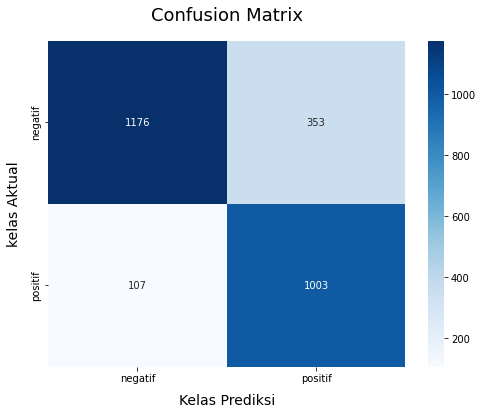

In [ ]:
# mempersiapkan library yang akan digunakan
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

# membuat heatmap
fig, ax = plt.subplots(figsize = (8,6))
heatmap = heatmap(confusion_matrix(x,y), annot=True, cmap = 'Blues', fmt='.0f')
ax.set_title("Confusion Matrix", fontdict = {'size':18}, pad = 20)
ax.grid(False)
ax.set_xlabel("Kelas Prediksi", fontdict = {'size':14}, labelpad = 10)
ax.set_xticklabels(['negatif', 'positif'])
ax.set_ylabel("kelas Aktual"   , fontdict = {'size':14}, labelpad = 10)
ax.set_yticklabels(['negatif', 'positif'])
plt.show()

### Wordcloud Sentimen Positif

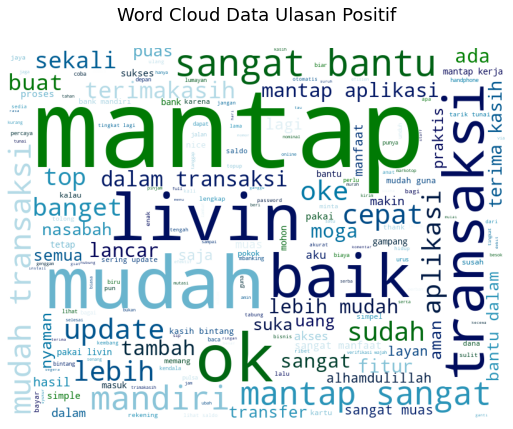

In [ ]:
# menyiapkan library yang akan digunakan
from wordcloud import WordCloud, ImageColorGenerator
import PIL.Image
import numpy as np

# mengambil data yang memiliki kelas klasifikasi positif
data_positif = databersih.loc[databersih['sentimen lexicon']=='positif']

# mengambil daftar kata dari data kelas positif
daftar_kata_positif=''
for ulasan in data_positif ['ulasan']:
    for kata in ulasan:
        daftar_kata_positif += ' '+(kata)

# membuat wordcloud dari daftar kata positif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='ocean', random_state=500,
                             min_font_size = 5).generate(daftar_kata_positif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud Data Ulasan Positif\n', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

### Top Ulasan Sentimen Positif

In [ ]:
# menampilkan 10 ulasan dengan total nilai polaritas tertinggi
pd.set_option('display.max_colwidth', 3000)
ulasan_positif = databersih[databersih['sentimen lexicon'] == 'positif']
ulasan_positif = ulasan_positif[['content', 'nilai polaritas', 'sentimen lexicon']].sort_values(by = 'nilai polaritas', ascending=False).reset_index(drop = True)
ulasan_positif.index += 1
ulasan_positif[0:10]

,content,nilai polaritas,sentimen lexicon
1,"Tolong Transaksi Tarik Tunai Tanpa Kartu Untuk Nominal 50.000 dihadir kan dalam fitur tarik tunai tanpa kartu, biar lebih mempermudah pengguna Mbank jika hanya ingin tarik tunai nominal 50.000",21,positif
2,"Mantap ,top markotop , recomend banget buat yang belum punya .. Buruan download nikmati kemudahan bertramsaksi dengan biaya murah dan bersahabat",19,positif
3,Sangat bermanfaat dalam transaksi non tunai... Tks,18,positif
4,Sungguh nyaman dan aman serta mudah untuk transaksi model apapun. Oke pokoknya.,18,positif
5,Alhamdulillah ...mandiri banyak membantu dg kmudahan2 dalam proses perbankan melalui aplikasi ini sampai saat ini... Semoga terus berinovasi dan memberikan pelayanan terbaik utk para nasabahnya. Terimakasih Mandiri....,17,positif
6,"Dlm minggu ini susah diakses, segera perbaiki, menyulitkan nasabah untuk transaksi. Padahal kami sdh percaya pakai jasa Mandiri????",16,positif
7,"Bagus buat transaksi, mempermudah pengguna, keamanan OKE.",16,positif
8,Bermanfaat dan memudahkan ketika mau bertransaksi secara cepat dan efisien. ???,16,positif
9,"Sangat bagus, memuaskan, sebagai nasabah saya merasa sangat terbantu & dimudahkan. Terimakasih",15,positif
10,Good good good,15,positif


### Wordcloud Sentimen Negatif

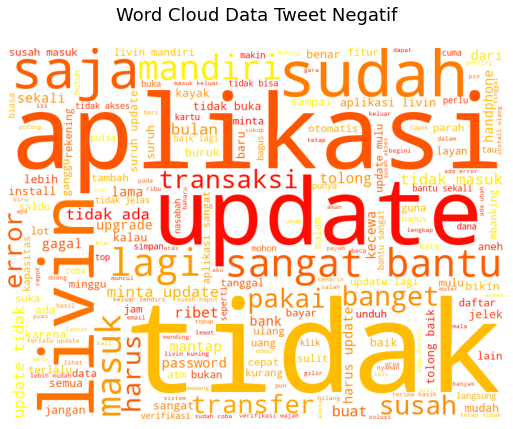

In [ ]:
# mengambil data yang memiliki kelas klasifikasi negatif
data_negatif = databersih.loc[databersih['sentimen lexicon']=='negatif']

# mengambil daftar kata dari data kelas negatif
daftar_kata_negatif=''
for ulasan in data_negatif ['ulasan']:
    for kata in ulasan:
        daftar_kata_negatif += ' '+(kata)

# membuat wordcloud dari daftar kata negatif
wordcloud = WordCloud(width = 800, height = 600, background_color = 'white', colormap='autumn', random_state=500,
                             min_font_size = 10).generate(daftar_kata_negatif)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud Data Tweet Negatif\n', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

### Top Ulasan Sentimen Negatif

In [ ]:
# menampilkan 10 ulasan dengan total nilai polaritas terendah
pd.set_option('display.max_colwidth', 3000)
ulasan_negatif = databersih[databersih['sentimen lexicon'] == 'negatif']
ulasan_negatif = ulasan_negatif[['content', 'nilai polaritas', 'sentimen lexicon']].sort_values(by = 'nilai polaritas', ascending=True).reset_index(drop = True)
ulasan_negatif.index += 1
ulasan_negatif[0:10]

,content,nilai polaritas,sentimen lexicon
1,"Adeeeh upgrade aja pake aktivasi lagi, pake pulsa lagi. HADEEEEEEH. RIBET BENER YA... Aplikasi Perbankan yang lain saya punya tidak pake aktivasi lagi TINGGAL SIGN IN. Jelas BGT TIDAK mau RUGI. Masalah saya yang sblm-sblmnya aja belum TUNTAS. ""aktivasi yang berkali-kali karena sign out dengan sendirinya"" INI suruh saya AKTIVASI LAGI SETELAH UP GRADE VERSI TER UP DATE. HADEH TEPUK TANGAN SAYA BUAT BANK MANDIRI. SALDO PULSA SAYA DI EMBAT, BIAYA ADMIN BULANAN DI EMBAT. SEMUANYA PAKE BIAYA. EDAAAN.",-82,negatif
2,"Nyesek pakai mandiri di suruh masuk daftar,,eh pas udah terdaftar, kebetulan HP lagi eror di suruh daftar lagi Klo gratis sih GPP ni pakai pulsa dlu,,dah gtu ga bisa sekali doank hrs berulang baru bisa pulsa dah kesedot banyak ????,,dah gitu saldo rekening hrs sisa cepek yg daftar saldo 500,ga kaya yg lain lain .. Klo bukan urusan kerja ga bakalan pakai mndiri, mengecewakan",-70,negatif
3,"Ini hp saya yg brengsek atau gimna ya? Tiap kali hbs buka aplikasi ini karna pihak mandiri mewajibkan pke aplikasi ini untuk mbangkingmya hp saya selalu error. Pdhl klo gk buka ini aplikasi hp saya aman2 aja lancar gk macet2. Tolong saya butuh penjelasan, dan bukan jawaban nanti akan jadi bahan perbaikan",-61,negatif
4,males banget livin mandiri skrng. cuman krna saya jualn online mknya tetep pakai buat cek transaksi. tau gini saya gk mau gnti ke livin gold. tiap kali mau transfer pdhal udh sering kerekening tujuan tapi gak kesave save. harus dketik ulang trus. sampai males. balikin lagi lah kelivin biru. minta upgrade tapi makin kuno. ksekelas mandiri yg udh punya nma masa gak bis cari pembuat aplikasi yang memadai. beneran kecewa,-58,negatif
5,"aplikasi jelek banget demiallah gara gara aplikasi aneh ini di update kaga bisaaa, padahal kondisi lagi kepepet banget. mana dikit dikit suruh update dikit dikit suruh update baperan amat wkwkwkw tolonglah aplikasi nya agak diperbaiki lagi ini merugikan banyak orang nanti?????????? Terimakasih",-56,negatif
6,"Sebenarnya saya suka dengan aplikasi Livin dari mandiri Tapi akhir2 ini baru mengklik aplikasi hanya 2 detik langsung keluar tanpa ada informasi lanjutan saya cek tidak ada pembaruan untuk aplikasi,, jaringan saya juga sangat bagus. Saya coba uninstall pas buka kembali registrasi seperti semula... Katanya tidak harus datang ke cabang atau ke atm Tapi saya registrasi kembali dan harus konfirmasi kembali ke atm mandiri Mana atm di daerah saya jauh lagi jaraknya.",-56,negatif
7,Sy Download aplikasi ini untuk transaksi usaha sy... Sdh berjalan 4 bln .tgl 19 Desember 2022 sy menerima transfer dr rekan usaha 2jt lbh tiba2 di debit ludes semua ..saldo sy tinggal RP NOL .. sgt tidak manusiawi pihak bank ini.. alasan yg mengada2 bhw katanya sy THN 2005 pernah pny kartu kredit yg blum tertutup.. itu tdk benar.! Kl pun benar..knp main langsung debit? Knp TDK ada pemberitahuan! Kl pun benar knp TDK sejak sy buka rekening ini ! Hati2 yg nabung jgn senasib dgn sy.makasih Mandiri,-55,negatif
8,"Saya bekerja di vital sector diluar negeri sehingga smartphone yang digunakan harus tanpa kamera. Pada saat instal baru LIVIN, dia mengharuskan scan wajah dan smartphone saya gak bisa melakukannya. Kenapa gak menggunakan cara yang dulu aja yang authentication lewat sms 3355. Lewat web pun tetep diarahkan lewat aplikasi livin",-47,negatif
9,"Selalu minta di update padahal sama aja, belum lama di update belum 1 bulan udah harus update lagi, cuma ngabis2in memori kuota. Buat yg memori terbatas n harus buru2 bayar ini itu jadi terhambat karena harus ngapus aplikasi yg lainnya",-45,negatif
10,Bikin rekening lewat livin untuk kperluan payroll. Tp ga ada pmberitahuan kartu atm nya ambil di mana. Hnya pake m.banking mlah tau2 ga bisa log in pdhal sandi nya dah bner. Reset sandi pun hrus pake nomor kartu. Astaga lg butuh uang malah kya begini aplikasi nya ????,-44,negatif


In [ ]:
databersih.to_csv("model lexicon-based.csv",index=False)

# Pembobotan TF-IDF
Term Frequency-Inverse Document Frequency (TF-IDF) adalah algoritma ekstraksi peubah (feature extraction) yang digunakan untuk mengetahui nilai bobot pada setiap kata (term). Metode ini merubah data yang telah diproses sebelumnya menjadi data numerik yang digunakan untuk membangun suatu model. Term Frequency (TF) merupakan frekuensi kemunculan suatu kata pada ulasan sedangkan Document Frequency (DF) merupakan banyaknya ulasan yang mengandung kata tersebut.

In [ ]:
# mengelompokkan dataset berdasarkan modelnya
data_lexicon = lexicon_tanpa_netral
data_hybrid = lexicon_tanpa_netral [['userName','at','score','content','ulasan']]
data_hybrid ['label lexicon'] = lexicon_tanpa_netral ['sentimen lexicon']
data_naivebayes = lexicon_tanpa_netral [['userName','at','score','content','ulasan','label manual']]

In [ ]:
# mengidentifikasi peubah
x1 = data_naivebayes['ulasan'].map(' '.join)
y1 = data_naivebayes['label manual']
x2 = data_hybrid['ulasan'].map(' '.join)
y2 = data_hybrid['label lexicon']

In [ ]:
# menerapkan fungsi TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(x1) #x1 untuk naive bayes x2 untuk hybrid

TfidfVectorizer()

In [ ]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

['abdate' 'abgret' 'abiiiissss' ... 'you' 'youtube' 'yuk']
1827


In [ ]:
# Melihat matriks jumlah fitur
x_tf_idf = tf_idf.transform(x1).toarray() #x1 untuk naive bayes x2 untuk hybrid
x_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Melihat matriks jumlah fitur menggunakan TF IDF
data_tf_idf = pd.DataFrame(x_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abdate,abgret,abiiiissss,acc,account,aco,acses,acung,ada,adakan,...,world,worth,yakali,ydahh,yess,ygy,yog,you,youtube,yuk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.271721,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pickle
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(x_tf_idf, output)

In [ ]:
data_tf_idf.to_csv("hasil tf-idf.csv", index=False)

# Seleksi Peubah
pemilihan fitur atau feature selection biasanya digunakan pada proses klasifikasi data untuk mereduksi dimensi data sehingga dapat mengefektifitaskan proses komputasi serta dapat meningkatkan hasil akurasi dari proses klasifikasi (Chen et al. 2006).

## Information Gain
Information gain mendeteksi setiap kata terhadap relevansi pada suatu kelas dengan melihat nilai maksimal dari entropy (Shaltout et al. 2014). entropy merupakan banyaknya informasi yang dibutuhkan untuk memodelkan suatu kata kedalam kelas tertentu (Maulida et al. 2016). Jika semakin besar nilai entropy dari suatu kata maka semakin baik kata dalam mengklasifikasikan ulasan ke dalam suatu kelas. Information gain bertujuan untuk merangkingkan kata dan menghapus kata yang tidak berpengaruh besar terhadap proses klasisifikasi (Fahrudy dan Uyun 2022).

In [ ]:
# mempersiapkan library Ig
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif

# inisiasi countvectorizer
igvect = CountVectorizer()

# fit data training
igvect.fit(x1) #x1 untuk naive bayes x2 untuk hybrid

# transform menjadi 'document-term matrix'
xig_dtm = igvect.transform(x1) #x1 untuk naive bayes x2 untuk hybrid

# hitung information gain
res1 = dict(zip(igvect.get_feature_names_out(),
               mutual_info_classif(xig_dtm, y1, discrete_features=True) #y1 untuk naive bayes y2 untuk hybrid
               ))
print(res1)


{'abdate': 0.0005468736439978522, 'abgret': 0.00027336085454662514, 'abiiiissss': 0.0002523835546041596, 'acc': 0.00027336085454662514, 'account': 0.0005468736439978522, 'aco': 0.0005468736439978522, 'acses': 0.0002523835546041596, 'acung': 0.0002523835546041596, 'ada': 0.012963848573307134, 'adakan': 0.00027336085454662514, 'adeeeh': 0.00027336085454662514, 'admin': 0.002740466835593508, 'administrasi': 0.00027336085454662514, 'adminnya': 0.00027336085454662514, 'admnya': 0.00027336085454662514, 'adpet': 0.00027336085454662514, 'adu': 0.0005468736439978522, 'aduh': 0.0019167227954028435, 'afa': 0.00027336085454662514, 'affairs': 0.0002523835546041596, 'afgrad': 0.00027336085454662514, 'aflikasi': 0.0002523835546041596, 'agal': 0.00027336085454662514, 'agar': 0.001642447681009001, 'aing': 0.00027336085454662514, 'ajiiip': 0.0002523835546041596, 'aju': 0.00027336085454662514, 'akal': 0.0005468736439978522, 'akhir': 0.00027336085454662514, 'akses': 0.0063508505531807875, 'aktif': 0.00027

In [ ]:
# hasil information gain diurutkan dari nilai terbesar
res = pd.DataFrame.from_dict(res1, orient='index', columns=['ig']).sort_values(by=['ig'], ascending=False)

#memilih fitur z terbesar
#nilai z merupakan rangking fitur yg dipilih
z = 400
features = res.iloc[:z].index.to_list()
non_features = res.iloc[z:].index.to_list()
res.iloc[:z]

,ig
update,0.143383
tidak,0.137344
mantap,0.087131
sangat,0.060675
bantu,0.059177
...,...
butuh,0.000716
simpel,0.000685
ketik,0.000672
wallet,0.000672


In [ ]:
# fit data dengan membuang kata yang tidak termasuk ig terbesar dalam tf idf
vect = TfidfVectorizer(stop_words = non_features)
vect.fit(x1) #x1 untuk naive bayes x2 untuk hybrid
x_seleksi_ig = vect.transform(x1).toarray() #x1 untuk naive bayes x2 untuk hybrid
x_seleksi_ig

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.2988337, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

## TF-IDF

In [ ]:
# seleksi fitur menggunakan nilai df
# mid_df min jumlah dokumen yg terdapat fitur, max_df nilai max df
seleksi_tfidf = TfidfVectorizer(min_df = 4, max_df = 0.5)
seleksi_tfidf.fit(x1) #x1 untuk naive bayes x2 untuk hybrid

TfidfVectorizer(max_df=0.5, min_df=4)

In [ ]:
# Melihat Jumlah Fitur
print(len(seleksi_tfidf.get_feature_names_out()))
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(seleksi_tfidf.get_feature_names_out())

413
['ada' 'admin' 'aduh' 'agar' 'akses' 'aktifitas' 'aku' 'akun' 'akurat'
 'alami' 'alhamdulilah' 'alhamdulillah' 'aman' 'amat' 'ambil' 'amin'
 'ampun' 'android' 'aneh' 'apa' 'aplikasi' 'asa' 'atas' 'atm' 'atur'
 'awal' 'baca' 'bagai' 'bagi' 'bagus' 'baharu' 'baik' 'balik' 'banget'
 'bank' 'bantu' 'banyak' 'baru' 'batu' 'bayar' 'beda' 'begini' 'belah'
 'beli' 'benah' 'benar' 'beres' 'beri' 'besar' 'biar' 'biasa' 'biaya'
 'bikin' 'bilang' 'bintang' 'biru' 'bisa' 'bisnis' 'blokir' 'bolak'
 'boleh' 'bos' 'bosan' 'buat' 'bug' 'buka' 'bukan' 'buku' 'bulan' 'bumn'
 'buru' 'buruk' 'butuh' 'by' 'cabang' 'cache' 'canggih' 'capek' 'cari'
 'cek' 'cepat' 'close' 'coba' 'cs' 'cukup' 'cuma' 'daerah' 'daftar'
 'dalam' 'dana' 'dapat' 'dari' 'darurat' 'data' 'datang' 'debit' 'dekat'
 'depan' 'desak' 'desember' 'detik' 'digital' 'dikit' 'doang' 'ecek'
 'efektif' 'efisien' 'email' 'emoney' 'enak' 'entah' 'error' 'fast'
 'fitur' 'force' 'foto' 'full' 'fungsi' 'gagal' 'gaje' 'gampang' 'ganggu'
 'ganti' 'g

In [ ]:
# Melihat matriks jumlah token

x_seleksi_tfidf = seleksi_tfidf.transform(x1).toarray() #x1 untuk naive bayes x2 untuk hybrid
x_seleksi_tfidf

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.2988337, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF

data_seleksi_tfidf = pd.DataFrame(x_seleksi_tfidf, columns=seleksi_tfidf.get_feature_names_out())
data_seleksi_tfidf

,ada,admin,aduh,agar,akses,aktifitas,aku,akun,akurat,alami,...,utama,va,verifikasi,vermuk,versi,wa,wajah,wajib,wallet,wifi
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.247239,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.687077,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2635,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2636,0.298834,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2637,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# melihat jumlah fitur sebelum dan sesudah di seleksi
sebelum = np.array(x_tfidf)
sesudah = np.array(x_seleksi_tfidf)
print('Seleksi Peubah dengan TF-IDF')
print('Sebelum Seleksi:',":", sebelum.shape[1])
print('Sesudah Seleksi:',":", sesudah.shape[1])

Seleksi Peubah dengan TF-IDF
Sebelum Seleksi: : 1827
Sesudah Seleksi: : 413


## Chi-Square

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
x_tfidf = np.array(data_tf_idf)
y_tfidf = np.array(y1) #y1 untuk naive bayes y2 untuk hybrid

In [ ]:
# mempersiapkan library chi square
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# memilih k fitur dengan nilai chi square tertinggi
chi2_features = SelectKBest(chi2, k=400)  #nilai k merupakan jumlah kata yang akan dipilih
x_seleksi_chi2 = chi2_features.fit_transform(x_tfidf, y_tfidf)

# menampilkan jumlah fitur sebelum dan sesudah di seleksi
print('Original feature number:', x_tfidf.shape[1])
print('Reduced feature number:', x_seleksi_chi2.shape[1])

Original feature number: 1827
Reduced feature number: 400


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
# Menampilkan kata beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
958,2.796993e+02,mantap
1763,1.450093e+02,update
1401,1.312148e+02,sangat
163,1.285962e+02,bantu
1669,1.129513e+02,tidak
...,...,...
1278,3.753363e-04,pro
1593,2.784999e-04,tahu
1060,2.008291e-04,mulai
874,1.328320e-04,layak


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([ True, False, False, ..., False, False, False])

In [ ]:
# Membuat list fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

# Cara melihat fitur yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

kbest_feature


{'mantap': 958,
 'aplikasi': 101,
 'kesel': 784,
 'kuning': 840,
 'susah': 1577,
 'buat': 270,
 'akses': 29,
 'mental': 1008,
 'mesti': 1015,
 'ulang': 1754,
 'update': 1763,
 'rusak': 1378,
 'vermuk': 1781,
 'tidak': 1669,
 'lagi': 851,
 'ganggu': 507,
 'topup': 1706,
 'dana': 353,
 'sudah': 1562,
 'minggu': 1020,
 'lebih': 879,
 'transaksi': 1715,
 'keluar': 759,
 'muncul': 1065,
 'masuk': 972,
 'semua': 1458,
 'akun': 36,
 'lama': 859,
 'hancur': 575,
 'begini': 183,
 'buruk': 291,
 'top': 1705,
 'pulsa': 1289,
 'tolong': 1697,
 'baik': 145,
 'daftar': 347,
 'foto': 490,
 'tinggal': 1678,
 'harap': 583,
 'jelas': 683,
 'salah': 1392,
 'password': 1200,
 'bikin': 224,
 'transfer': 1716,
 'developer': 388,
 'thanks': 1663,
 'bulan': 282,
 'pakai': 1184,
 'langsung': 866,
 'install': 643,
 'handphone': 577,
 'lain': 852,
 'mandiri': 949,
 'tetap': 1658,
 'buka': 275,
 'close': 327,
 'selfie': 1450,
 'pada': 1179,
 'lewat': 890,
 'henti': 602,
 'awal': 126,
 'doang': 421,
 'terang': 163

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(x_seleksi_chi2, columns=selected_feature)
data_selected_feature

,abdate,ada,admin,aduh,agar,akses,aktifitas,aktivasi,akun,akurat,...,uras,usah,verifikasi,vermuk,versi,virtual,wa,wajah,wajib,wifi
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.247239,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.687077,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2635,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2636,0.0,0.271721,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2637,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Pemodelan *Naive Bayes* dan *Hybrid*
Pemodelan klasifikasi pada tahap ini dilakukan menggunakan metode multinomial naive bayes. Model klasifikasi dibangun menggunakan bantuan package dari library Scikit-Learn bernama MultinomialNB berdasarkan data training pada masing-masing dataset

## Multinomial Naive bayes
Metode Multinomial naive bayes dinilai lebih informatif karena metode ini menghitung frekuensi kemunculan kata pada suatu ulasan (Xu 2016). Pemodelan pada metode multinomial naive bayes berbasis machine learning dimana model yang dibangun merupakan pembelajaran atas data training yang telah diberi label sebelumnya. pada metode ini data dibagi dengan perbandingan 9:1 secara stratifikasi pada masing-masing kelasnya

In [ ]:
# mempersiapkan library MNB
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

# Proses memisahkan data uji dan data latih secara stratifikasi. Perbandingan 90% untuk data latih, 10% untuk data uji
# x_tf_idf tanpa seleksi fitur, x_seleksi_ig information gain, x_seleksi_tfidf tfidf, x_seleksi_chi2 chi square
# y1 untuk naive bayes y2 untuk hybrid

X_train, X_test, y_train, y_test = train_test_split(x_seleksi_ig, y1, test_size=0.1, random_state=2, stratify=y1)

# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

## Evaluasi Model

In [ ]:
# evaluasi model klasifikasi multinomial naive bayes
from sklearn.metrics import classification_report

print("Confusion Matrix:")
print(confusion_matrix(model_pred,y_test))
print("Accuracy" , accuracy_score(model_pred,y_test))
print(classification_report(model_pred,y_test))

Confusion Matrix:
[[124   5]
 [  4 131]]
Accuracy 0.9659090909090909
              precision    recall  f1-score   support

     negatif       0.97      0.96      0.96       129
     positif       0.96      0.97      0.97       135

    accuracy                           0.97       264
   macro avg       0.97      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264



## Heatmap

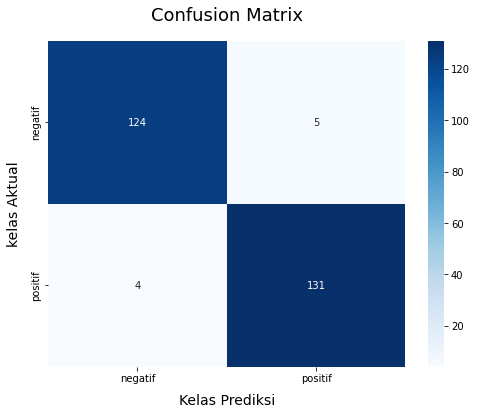

In [ ]:
# mempersiapkan library yang akan digunakan
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import matplotlib.pyplot as plt

# membuat heatmap
fig, ax = plt.subplots(figsize = (8,6))
heatmap = heatmap(confusion_matrix(model_pred,y_test), annot=True, cmap = 'Blues', fmt='.0f')
ax.set_title("Confusion Matrix", fontdict = {'size':18}, pad = 20)
ax.grid(False)
ax.set_xlabel("Kelas Prediksi", fontdict = {'size':14}, labelpad = 10)
ax.set_xticklabels(['negatif', 'positif'])
ax.set_ylabel("kelas Aktual"   , fontdict = {'size':14}, labelpad = 10)
ax.set_yticklabels(['negatif', 'positif'])
plt.show()

## *Stratified k-Fold Cross Validation*
Metode ini membagi data atau ulasan secara stratifikasi pada setiap sentimen sehingga masing-masing bagian dapat lebih merepresentasikan keseluruhan data. k-fold cross validation membagi keseluruhan ulasan kedalam k bagian sama besar yang disebut dengan lipatan (fold), kemudian melakukan proses training dan testing yang diulang sebanyak k kali sehingga setiap ulasan pernah berperan sebagai data latih maupun data uji (Hadna et al. 2016).

In [ ]:
# mempersiapkan library Stratified k-Fold Cross Validation
from sklearn.model_selection import RepeatedStratifiedKFold    # teknik cross validation yang digunakan
from sklearn.model_selection import cross_val_score   # untuk mengetahui performa model pada cross validation

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=50)

# x_tf_idf tanpa seleksi fitur, x_seleksi_ig information gain, x_seleksi_tfidf tfidf, x_seleksi_chi2 chi square
# x1 untuk naive bayes x2 untuk hybrid
cv_accuracy = (cross_val_score(model,x_seleksi_ig , y1, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.96212121 0.95454545 0.95833333 0.97727273 0.97348485 0.95833333
 0.95833333 0.96590909 0.97727273 0.97718631 0.96590909 0.96212121
 0.98106061 0.95833333 0.95833333 0.96590909 0.96969697 0.97348485
 0.96212121 0.96197719 0.96590909 0.95454545 0.97348485 0.96969697
 0.96969697 0.96969697 0.96969697 0.95833333 0.95454545 0.97338403
 0.95454545 0.96969697 0.99242424 0.97727273 0.95833333 0.97348485
 0.95833333 0.96590909 0.95454545 0.96577947 0.97727273 0.96212121
 0.98484848 0.96590909 0.97727273 0.96590909 0.94318182 0.94318182
 0.96212121 0.97718631 0.96590909 0.97348485 0.97727273 0.97727273
 0.9469697  0.95454545 0.94318182 0.98484848 0.98484848 0.95057034
 0.96212121 0.97348485 0.96590909 0.95833333 0.94318182 0.95833333
 0.98484848 0.95833333 0.97727273 0.96958175 0.97348485 0.97348485
 0.93560606 0.95454545 0.98484848 0.98863636 0.95833333 0.96212121
 0.95075758 0.98098859 0.97727273 0.95833333 0.97348485 0.99242424
 0.96212121 0.95454545 0.93560606 0.9734

In [ ]:
# x_tf_idf tanpa seleksi fitur, x_seleksi_ig information gain, x_seleksi_tfidf tfidf, x_seleksi_chi2 chi square
# x1 untuk naive bayes x2 untuk hybrid
cv_f1score = (cross_val_score(model,x_seleksi_ig , y1, cv=cv, scoring='f1_macro'))
avg_f1score = np.mean(cv_f1score)

print('f1_macro setiap split:', cv_f1score, '\n')
print('Rata-rata f1_macro pada cross validation:', avg_f1score)

f1_macro setiap split: [0.9620864  0.95454545 0.95830402 0.97726098 0.97347533 0.95830402
 0.95832795 0.96589686 0.97726751 0.97718334 0.96590469 0.9620864
 0.98104728 0.95831838 0.95830402 0.96589686 0.96965343 0.97348142
 0.96211251 0.96197224 0.96590469 0.95454285 0.973454   0.96969001
 0.96969001 0.96966912 0.96969001 0.95832795 0.95452196 0.97337787
 0.95453502 0.96965343 0.99241728 0.97727142 0.95832795 0.973454
 0.95831838 0.9659086  0.95454285 0.96577155 0.97724007 0.96210164
 0.98483456 0.9659086  0.97726751 0.96590469 0.94314184 0.94317448
 0.96211251 0.97717806 0.9659086  0.97348142 0.97726098 0.97726098
 0.94694229 0.95445135 0.94316143 0.98484065 0.98484501 0.95057034
 0.96212121 0.97346619 0.96586942 0.95831838 0.943181   0.95831838
 0.98483456 0.95831838 0.97727142 0.96957779 0.97346619 0.97348142
 0.93560514 0.95452196 0.98482671 0.98863229 0.95831838 0.96212121
 0.95073991 0.98097099 0.97726098 0.95831838 0.97347533 0.99241336
 0.96211904 0.95450368 0.93560514 0.973475